Step1: This part is optional, i used it to load data directly from kaggle platform: [link of  data(Kaggle)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
! cp /content/kaggle.json  ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s "Chest X-Ray Images (Pneumonia)"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d /content/chest_Dataset

Step2: Import required librairies

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

Step3: Set dataset path

In [ ]:
data_dir = '/content/chest_Dataset/chest_xray/'  # Base directory containing train, test, and val folders
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
def load_data(directory, image_size=(150, 150)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels), class_names

In [ ]:
# Load train, validation, and test datasets
X_train, y_train, classes = load_data(train_dir)
X_val, y_val, _ = load_data(val_dir)
X_test, y_test, _ = load_data(test_dir)

In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

Step7: Convert labels to categorical format for binary classification

In [ ]:
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

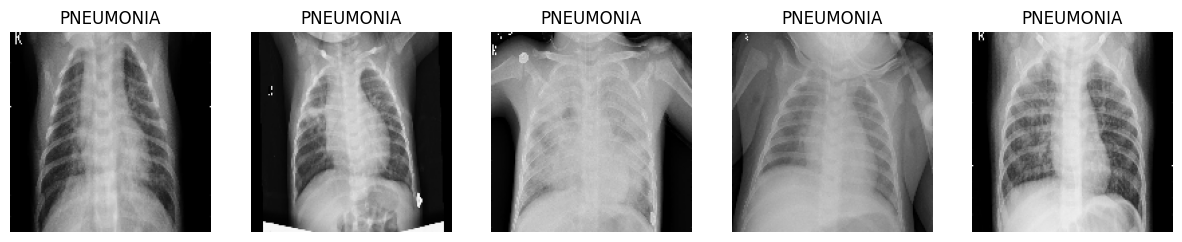

In [ ]:
# Step 4: Visualize Sample Images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(classes[np.argmax(y_train[i])])
    ax.axis('off')
plt.show()


In [ ]:
# Step 5: Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 6: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7482 - loss: 1.5294 - val_accuracy: 0.6250 - val_loss: 0.7942
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9294 - loss: 0.4237 - val_accuracy: 0.7500 - val_loss: 0.6709
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9214 - loss: 0.3919 - val_accuracy: 0.8125 - val_loss: 0.8444
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9380 - loss: 0.3122 - val_accuracy: 0.8125 - val_loss: 0.6073
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.9368 - loss: 0.2986 - val_accuracy: 0.7500 - val_loss: 0.5411
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9363 - loss: 0.3043 - val_accuracy: 0.8125 - val_loss: 0.4973
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9391 - loss: 0.2819 - val_accuracy: 0.8125 - val_loss: 0.8047
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9461 - loss: 0.2491 - val_accu

In [ ]:
# Step 7: Evaluate the Model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7500 - loss: 0.5248
Validation Accuracy: 75.00%


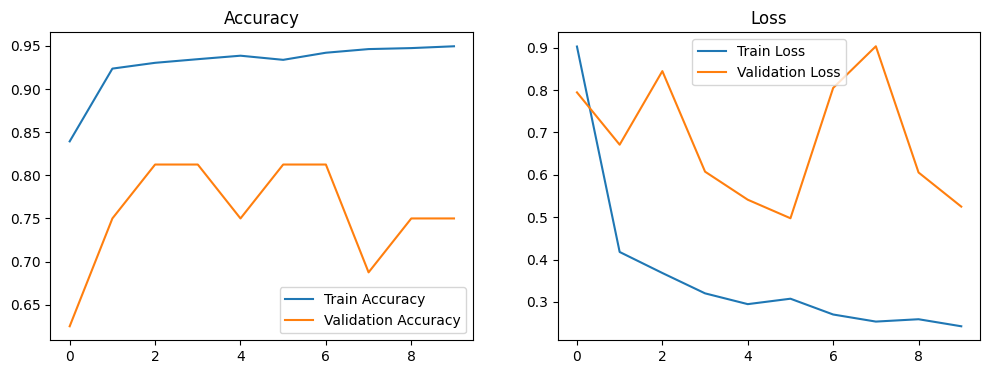

In [ ]:
# Step 8: Visualize Training Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# Step 9: Test the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 436ms/step - accuracy: 0.9296 - loss: 0.3011
Test Accuracy: 87.82%


In [ ]:
# Predict on Test Images
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step


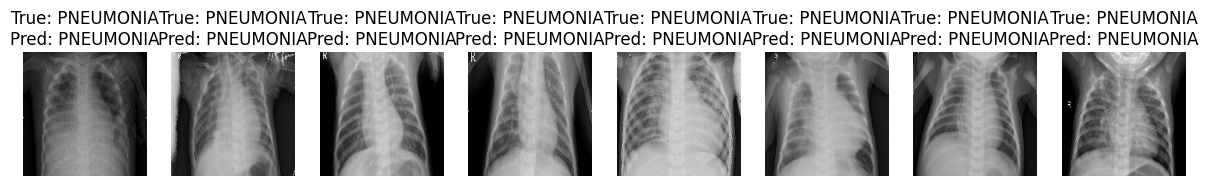

In [ ]:
# Show Real and Predicted Classes with Images
fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])
    true_label = classes[true_classes[i]]
    predicted_label = classes[predicted_classes[i]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis('off')
plt.show()

In [ ]:
import seaborn as sns

              precision    recall  f1-score   support

   PNEUMONIA       0.87      0.95      0.91       390
      NORMAL       0.90      0.76      0.82       234

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



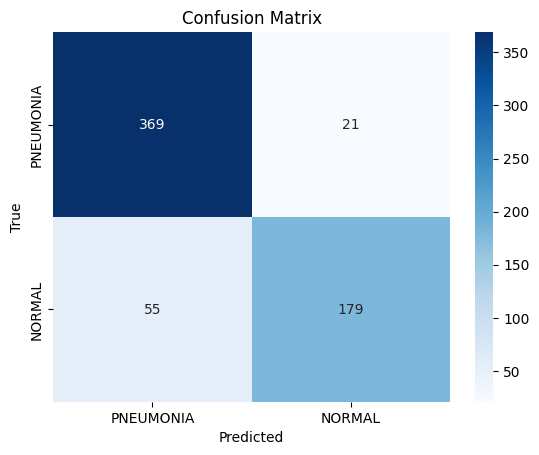

In [ ]:
# Classification Report and Confusion Matrix
print(classification_report(true_classes, predicted_classes, target_names=classes))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()